In [2]:
# Task : predict the sales in Japan using sales in North America/Europe and other attributes such as the name of the game, the platform, the genre, and the publisher.

In [3]:
import pandas as pd

# load the dataset 
df_vg = pd.read_csv('vgsales.csv') 

# lowercase column names
df_vg.columns = df_vg.columns.str.lower()

In [4]:
import numpy as np

# Apply log transformation to all sales columns
sales_columns = ["na_sales", "eu_sales", "jp_sales", "other_sales", "global_sales"]
df_vg[sales_columns] = df_vg[sales_columns].apply(np.log1p)  # log(1 + x) transformation

In [5]:
# Compute the ratio of JP sales to NA+EU sales
df_vg['jp_ratio'] = df_vg['jp_sales'] / (df_vg['na_sales'] + df_vg['eu_sales'] + 1e-6)  # Avoid division by zero

# Compute IQR to detect outliers
Q1, Q3 = df_vg['jp_ratio'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Separate outliers and inliers
df_outlier = df_vg[(df_vg['jp_ratio'] < lower_bound) | (df_vg['jp_ratio'] > upper_bound)]  # Outliers
df_cleaned = df_vg[(df_vg['jp_ratio'] >= lower_bound) & (df_vg['jp_ratio'] <= upper_bound)]  # Inliers

In [6]:
print(f"Original dataset: {len(df_vg)} rows")
print(f"Outliers removed: {len(df_outlier)} rows")
print(f"Cleaned dataset: {len(df_cleaned)} rows")

Original dataset: 16598 rows
Outliers removed: 3659 rows
Cleaned dataset: 12939 rows


In [7]:
# filter the dataset 
# (We only need games that were actually sold in Japan - since we are trying to predict jp_sales / 
# indeed, either na_sales or eu_sales must have sold more than 0 - since we are predicting jp_sales based on na & eu sales)

df_last = df_cleaned[
    (df_cleaned['jp_sales'] > 0) & 
    ((df_cleaned['na_sales'] > 0) | (df_cleaned['eu_sales'] > 0))]

In [8]:
# copy and name the dataset to 'df'

df = df_last.copy()

In [9]:
df.shape

(2484, 12)

In [10]:
# check for missing values

df.isnull().sum()

rank             0
name             0
platform         0
year            16
genre            0
publisher        1
na_sales         0
eu_sales         0
jp_sales         0
other_sales      0
global_sales     0
jp_ratio         0
dtype: int64

In [11]:
import numpy as np
# replace missing values with the mode (most recurrent value)

df['year'] = df['year'].fillna(df['year'].mode()[0])
df['publisher'] = df['publisher'].replace(np.nan, df['publisher'].mode()[0])

In [12]:
df.isnull().sum()

rank            0
name            0
platform        0
year            0
genre           0
publisher       0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
global_sales    0
jp_ratio        0
dtype: int64

In [13]:
df.shape

(2484, 12)

In [14]:
df.head(75)

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales,jp_ratio
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,3.749269,3.401864,1.562346,2.247072,4.427717,0.218475
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,3.403860,1.521699,2.055405,0.570980,3.719409,0.417294
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,2.824351,2.630449,1.566530,1.460938,3.606041,0.287184
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,2.818398,2.485740,1.453953,1.376244,3.526361,0.274117
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,2.507157,2.291524,2.417698,0.693147,3.477232,0.503825
...,...,...,...,...,...,...,...,...,...,...,...,...
71,72,Donkey Kong Country,SNES,1994.0,Platform,Nintendo,1.678964,0.996949,1.386294,0.207014,2.332144,0.518064
72,73,Minecraft,X360,2013.0,Misc,Microsoft Game Studios,1.884035,1.342865,0.019803,0.570980,2.322388,0.006137
73,74,Animal Crossing: New Leaf,3DS,2012.0,Simulation,Nintendo,1.101940,1.199965,1.678964,0.343590,2.311545,0.729380
74,75,Mario Party DS,DS,2007.0,Misc,Nintendo,1.697449,1.057790,1.091923,0.530628,2.304583,0.396308


In [15]:
# feature engineering -- creating new columns

In [16]:
# Since there are many publishers, we will group them together and call it 'small publisher'.

# Step 1: Count occurrences of each publisher
publisher_counts = df['publisher'].value_counts()

# Step 2: Create a new column 'publisher_category' to categorize publishers
df['publisher_category'] = df['publisher'].map(lambda x: 'small publisher' if publisher_counts.get(x, 0) < 100 else x)

# Now 'publisher_category' is a column.

In [17]:
# sum of na_sales and eu_sales

df.loc[:, 'na_eu_sales'] = df.loc[:, 'na_sales'] + df.loc[:, 'eu_sales']

df.loc[:, 'na_eu_sales_interaction'] = df.loc[:, 'na_sales'] * df.loc[:, 'eu_sales']

In [18]:
# Determine the share of na_sales and eu_sales in global_sales for each publisher.

# Group by publisher and calculate the sum of sales
publisher_sales = df.groupby('publisher')[['na_sales', 'eu_sales', 'global_sales']].sum()

# Calculate the percentage of NA sales for each publisher
publisher_sales['na_publisher_dominance'] = (publisher_sales['na_sales'] / publisher_sales['global_sales']) * 100

# Calculate the percentage of EU sales for each publisher
publisher_sales['eu_publisher_dominance'] = (publisher_sales['eu_sales'] / publisher_sales['global_sales']) * 100

# Calculate the combined percentage of NA + EU sales for each publisher
publisher_sales['na_eu_publisher_dominance'] = (publisher_sales['na_sales'] + publisher_sales['eu_sales']) / publisher_sales['global_sales'] * 100

# Merge back to the original DataFrame
df = df.merge(publisher_sales[['na_eu_publisher_dominance']], on='publisher', how='left')

In [19]:
df['genre_na_sales'] = df.groupby('genre')['na_sales'].transform('sum')
df['genre_eu_sales'] = df.groupby('genre')['eu_sales'].transform('sum')

df['publisher_na_sales'] = df.groupby('publisher')['na_sales'].transform('sum')
df['publisher_eu_sales'] = df.groupby('publisher')['eu_sales'].transform('sum')

df['platform_na_sales'] = df.groupby('platform')['na_sales'].transform('sum')
df['platform_eu_sales'] = df.groupby('platform')['eu_sales'].transform('sum')

In [20]:
df.head(75)

,rank,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,...,publisher_category,na_eu_sales,na_eu_sales_interaction,na_eu_publisher_dominance,genre_na_sales,genre_eu_sales,publisher_na_sales,publisher_eu_sales,platform_na_sales,platform_eu_sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,3.749269,3.401864,1.562346,2.247072,...,Nintendo,7.151133,12.754502,103.420376,104.918937,103.031334,325.363057,199.961609,91.876400,65.237414
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,3.403860,1.521699,2.055405,0.570980,...,Nintendo,4.925559,5.179651,103.420376,141.205235,82.720280,325.363057,199.961609,42.888275,13.977544
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,2.824351,2.630449,1.566530,1.460938,...,Nintendo,5.454800,7.429310,103.420376,87.049159,80.290473,325.363057,199.961609,91.876400,65.237414
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,2.818398,2.485740,1.453953,1.376244,...,Nintendo,5.304138,7.005804,103.420376,104.918937,103.031334,325.363057,199.961609,91.876400,65.237414
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,2.507157,2.291524,2.417698,0.693147,...,Nintendo,4.798681,5.745211,103.420376,139.958848,83.469570,325.363057,199.961609,43.317531,25.261807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,72,Donkey Kong Country,SNES,1994.0,Platform,Nintendo,1.678964,0.996949,1.386294,0.207014,...,Nintendo,2.675913,1.673841,103.420376,141.205235,82.720280,325.363057,199.961609,24.771242,11.702303
71,73,Minecraft,X360,2013.0,Misc,Microsoft Game Studios,1.884035,1.342865,0.019803,0.570980,...,small publisher,3.226900,2.530004,121.116263,64.901983,45.133481,53.282637,33.144514,176.510915,113.084739
72,74,Animal Crossing: New Leaf,3DS,2012.0,Simulation,Nintendo,1.101940,1.199965,1.678964,0.343590,...,Nintendo,2.301905,1.322289,103.420376,38.171054,26.420791,325.363057,199.961609,39.095291,31.327011
73,75,Mario Party DS,DS,2007.0,Misc,Nintendo,1.697449,1.057790,1.091923,0.530628,...,Nintendo,2.755239,1.795545,103.420376,64.901983,45.133481,325.363057,199.961609,86.931575,53.512245


In [21]:
# check columns 

df.columns

Index(['rank', 'name', 'platform', 'year', 'genre', 'publisher', 'na_sales',
       'eu_sales', 'jp_sales', 'other_sales', 'global_sales', 'jp_ratio',
       'publisher_category', 'na_eu_sales', 'na_eu_sales_interaction',
       'na_eu_publisher_dominance', 'genre_na_sales', 'genre_eu_sales',
       'publisher_na_sales', 'publisher_eu_sales', 'platform_na_sales',
       'platform_eu_sales'],
      dtype='object')

In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import numpy as np

# Create sales bins -- stratify the dataset so that the data can be divided more equally in terms of sales. 
df = df.copy()
df['sales_bin'] = pd.qcut(df['na_sales'], q=2, labels=['low', 'high'])
# na_sales

# Split features and target variable
X = df.drop(['rank', 'name', 'jp_sales', 'other_sales', 
             'global_sales', 'publisher', 'jp_ratio'], axis=1)  # Features
y = df['jp_sales']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X,  # Features
    y,  # Target variable (jp_sales)
    test_size=0.2,  # 20% for testing
    stratify=df['sales_bin'],  # Stratify based on the sales bin
    random_state=42  # For reproducibility
)

# Check the distribution of the 'sales_bin' in both sets
print("Training set distribution:")
print(X_train['sales_bin'].value_counts())
print("Test set distribution:")
print(X_test['sales_bin'].value_counts())   

X_train = X_train.drop(columns=['sales_bin'])
X_test = X_test.drop(columns=['sales_bin'])

# Define numeric features and their transformer
numeric_features = ['year',
                    'na_sales', 
                    'eu_sales',
                    'na_eu_sales', 
                    'na_eu_publisher_dominance',
                    'na_eu_sales_interaction',
                    'genre_na_sales',
                    'genre_eu_sales',
                    'publisher_na_sales', 
                    'publisher_eu_sales', 
                    'platform_na_sales',
                    'platform_eu_sales']
numeric_transformer = StandardScaler()

# Define categorical features and their transformer
categorical_features = ['platform', 
                        'genre', 
                        'publisher_category']
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Training set distribution:
sales_bin
low     999
high    988
Name: count, dtype: int64
Test set distribution:
sales_bin
low     250
high    247
Name: count, dtype: int64


In [23]:
# Initialize RandomForestRegressor
regressor = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)

# Create a pipeline that first transforms the data and then applies the regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Perform K-Fold Cross-Validation (R² score)
cv_scores_r2 = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')

# Print cross-validation results
print("Mean CV R² Score:", cv_scores_r2.mean())
print(f"Cross-validation R² scores: {cv_scores_r2}")
print(f"Standard deviation of R²: {cv_scores_r2.std():.4f}")

# Fit the pipeline on the training set
pipeline.fit(X_train, y_train)

# Predict on training set and test set
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Calculate and print additional metrics for the test set
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Compute R² on log-transformed scale
print(f"Train R² (log scale): {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R² (log scale): {r2_score(y_test, y_pred_test):.4f}")

Mean CV R² Score: 0.7228028053238724
Cross-validation R² scores: [0.58432895 0.62910829 0.80679119 0.72666971 0.72014889 0.78496629
 0.64126021 0.81715995 0.79370174 0.72389284]
Standard deviation of R²: 0.0771
Test MAE: 0.0729
Test RMSE: 0.1255
Train R² (log scale): 0.9158
Test R² (log scale): 0.7857


In [24]:
# Retrieve feature importances
importances = pipeline.named_steps['regressor'].feature_importances_

# Get feature names
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Visualize feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df.head(20))

                                    Feature  Importance
3                          num__na_eu_sales    0.135254
5              num__na_eu_sales_interaction    0.122457
1                             num__na_sales    0.116421
2                             num__eu_sales    0.100416
9                   num__publisher_eu_sales    0.075831
8                   num__publisher_na_sales    0.071960
51         cat__publisher_category_Nintendo    0.070181
0                                 num__year    0.053505
4            num__na_eu_publisher_dominance    0.043937
11                   num__platform_eu_sales    0.025923
7                       num__genre_eu_sales    0.025502
10                   num__platform_na_sales    0.022074
6                       num__genre_na_sales    0.018199
55  cat__publisher_category_small publisher    0.015979
42                  cat__genre_Role-Playing    0.010329
15                         cat__platform_GB    0.006621
29                       cat__platform_SNES    0

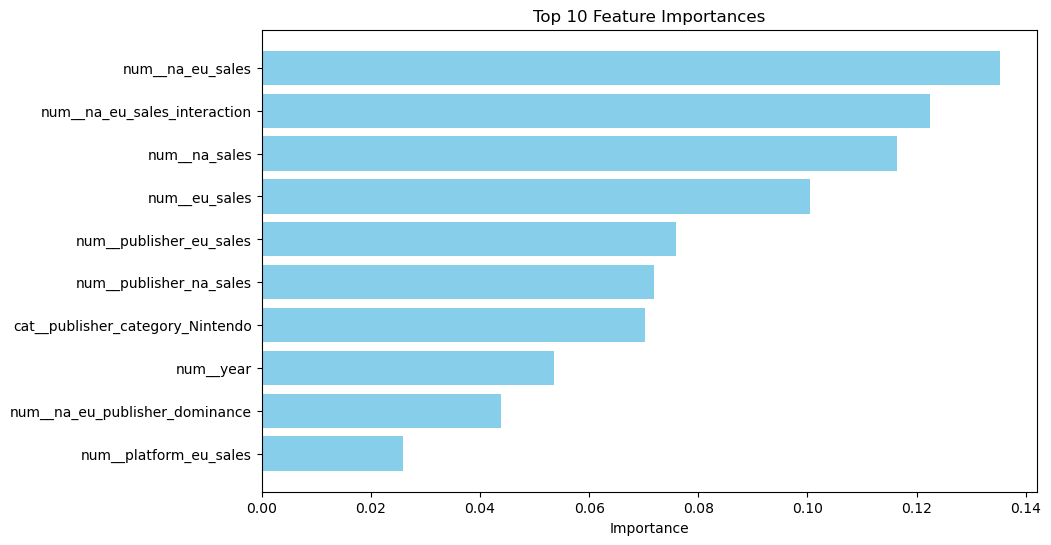

In [25]:
import matplotlib.pyplot as plt

# Top 10 most important features
top_10_features = importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [26]:
# Reverse transformation (convert back to original scale) if a log transformation was applied
# Make sure to apply np.expm1() only if the target was previously log-transformed
y_train_original = np.expm1(y_train)  # Only if y was log-transformed
y_test_original = np.expm1(y_test)    # Only if y was log-transformed
y_pred_train_original = np.expm1(y_pred_train)  # Only if predictions need reversing
y_pred_test_original = np.expm1(y_pred_test)    # Only if predictions need reversing

# Compute evaluation metrics on original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mae_original = mean_absolute_error(y_test_original, y_pred_test_original)
mse_original = mean_squared_error(y_test_original, y_pred_test_original)
r2_train_original = r2_score(y_train_original, y_pred_train_original)
r2_test_original = r2_score(y_test_original, y_pred_test_original)

# Print results
print(f"RMSE on original scale: {rmse_original:.4f}")
# print(f"MAE on original scale: {mae_original:.4f}")
# print(f"MSE on original scale: {mse_original:.4f}")
print(f"Train R² (original scale): {r2_train_original:.4f}")
print(f"Test R² (original scale): {r2_test_original:.4f}")

RMSE on original scale: 0.2840
Train R² (original scale): 0.9052
Test R² (original scale): 0.7950


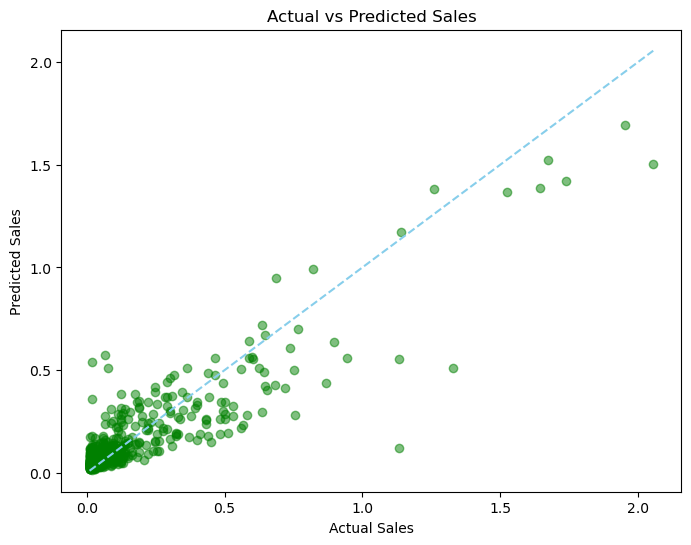

In [27]:
import matplotlib.pyplot as plt
# Actual vs Predicted Sales

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='skyblue', linestyle='--')  # Ideal line
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.show()

In [28]:
from sklearn.utils import resample

# Bootstrapping for Confidence Intervals
n_iterations = 1000
metrics = {'MSE': [], 'MAE': [], 'R2': []}

for _ in range(n_iterations):
    indices = resample(range(len(y_test)), replace=True)
    y_test_sample = np.array(y_test)[indices]
    y_pred_sample = np.array(y_pred_test)[indices]
    
    # Reverse the log transformation using np.expm1()
    y_test_sample_original = np.expm1(y_test_sample)
    y_pred_sample_original = np.expm1(y_pred_sample)
    
    # Calculate the metrics on the original scale
    metrics['MSE'].append(mean_squared_error(y_test_sample_original, y_pred_sample_original)) 
    metrics['MAE'].append(mean_absolute_error(y_test_sample_original, y_pred_sample_original)) 
    metrics['R2'].append(r2_score(y_test_sample_original, y_pred_sample_original))

# Calculate Confidence Intervals
for metric, values in metrics.items():
    lower = np.percentile(values, 2.5)
    upper = np.percentile(values, 97.5)
    print(f"{metric} 95% CI: [{lower:.4f}, {upper:.4f}]")

MSE 95% CI: [0.0378, 0.1471]
MAE 95% CI: [0.0942, 0.1395]
R2 95% CI: [0.6684, 0.8660]
